In [9]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

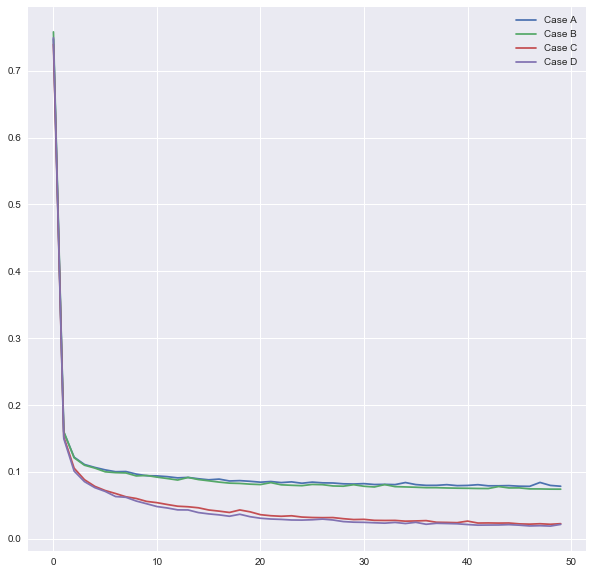

In [38]:
# plot the convergence
a_convergence = np.load('a_convergence_curve.npy')
b_convergence = np.load('b_convergence_curve.npy')
c_convergence = np.load('c_convergence_curve.npy')
d_convergence = np.load('d_convergence_curve.npy')

plt.figure(figsize=(10,10))
plt.plot(a_convergence,label='Case A')
plt.plot(b_convergence,label='Case B')
plt.plot(c_convergence,label='Case C')
plt.plot(d_convergence,label='Case D')
plt.legend()
plt.show()

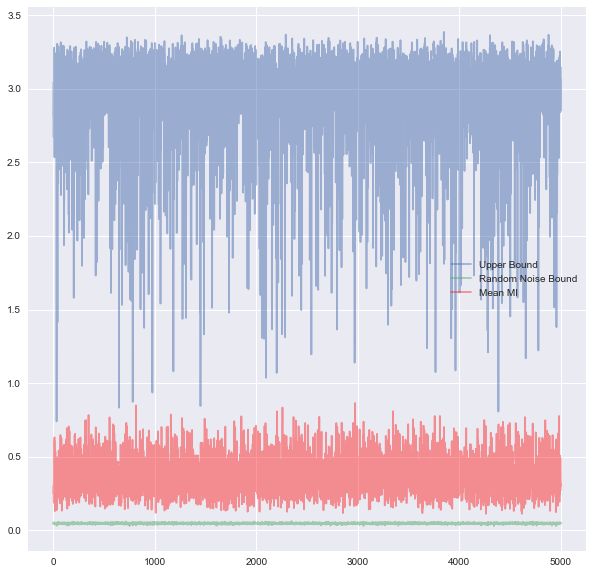

In [68]:
# plot the MI
a_mi = np.load('a_MI.npy')

plt.figure(figsize=(10,10))
plt.plot(a_mi[:,0],label='Upper Bound',alpha=0.5)
plt.plot(a_mi[:,1],label='Random Noise Bound',alpha=0.5)
plt.plot(a_mi[:,4],label='Mean MI',color='Red',alpha=0.4)
plt.legend()
plt.show()

